In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

#fname = "root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/127C2975-1B1C-A046-AABF-62B77E757A86.root"
fname = "file:/opendata_cms/DoubleMuon/Run2016H-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD/127C2975-1B1C-A046-AABF-62B77E757A86.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DoubleMuon"},
).events()

print("Number of events = ", ak.num(events.Muon, axis=0).compute())

/usr/local/venv/lib/python3.10/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/usr/local/venv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/venv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cr

Number of events =  2147195


In [2]:
print("Number of muons = ", ak.count(events.Muon.mass, axis=None).compute())

Number of muons =  4806013


In [3]:
selected_muons = events.Muon[(events.Muon.isGlobal == 1)]
print("Number of selected muons after isGlobal==1: ", ak.count(selected_muons.mass, axis=None).compute())

Number of selected muons after isGlobal==1:  4110800


In [4]:
selected_muons = selected_muons[(selected_muons.nStations > 0)]
print("Number of selected muons after nStations>0: ", ak.count(selected_muons.mass, axis=None).compute())

Number of selected muons after nStations>0:  3936437


In [5]:
selected_muons = selected_muons[(selected_muons.nTrackerLayers > 5)]
print("Number of selected muons after nTrackerLayers>5: ", ak.count(selected_muons.mass, axis=None).compute())

Number of selected muons after nTrackerLayers>5:  3908889


In [6]:
selected_muons = selected_muons[(selected_muons.dxy < 0.3) & (selected_muons.dz < 20.0)]
print("Number of selected muons after PV impact param sel: ", ak.count(selected_muons.mass, axis=None).compute())       

Number of selected muons after PV impact param sel:  3892547


In [7]:
selected_muons = selected_muons[(selected_muons.pt > 3.0) & (abs(selected_muons.eta) < 2.4)]
print("Number of selected muons after pt,eta sel: ", ak.count(selected_muons.mass, axis=None).compute())

Number of selected muons after pt,eta sel:  3883500


In [8]:
selected_muons = selected_muons[(selected_muons.pfRelIso03_chg < 0.5)]
print("Number of selected muons after ptcone30 isolation: ", ak.count(selected_muons.mass, axis=None).compute())

Number of selected muons after ptcone30 isolation:  2681124


In [9]:
selectede_muons = selected_muons[ak.num(selected_muons) > 0]
print("Number of selected events with num(muons)>0: ", ak.num(selectede_muons.mass, axis=0).compute())
print("Corresponding number of selected muons: ", ak.count(selectede_muons.mass, axis=None).compute())

Number of selected events with num(muons)>0:  1604214
Corresponding number of selected muons:  2681124


In [10]:
#selected_muons_c = selected_muons.compute()
pass

In [11]:
fourmuon = ak.combinations(selected_muons, 4, fields=['lep1','lep2','lep3','lep4'])

In [12]:
print(type(fourmuon))

<class 'dask_awkward.lib.core.Array'>


In [13]:
print("Number of 4-muon combination: ", ak.count(fourmuon.lep1.mass, axis=None).compute())

Number of 4-muon combination:  6170


In [14]:
fourmuon = fourmuon[(fourmuon.lep1.charge + fourmuon.lep2.charge == 0) &
                    (fourmuon.lep3.charge + fourmuon.lep4.charge == 0)]

In [15]:
print("Number of 4-muon combination after charge check: ", ak.count(fourmuon.lep1.mass, axis=None).compute())

Number of 4-muon combination after charge check:  2304


In [16]:
fourmuon["pair1"] = fourmuon.lep1 + fourmuon.lep2
fourmuon["pair2"] = fourmuon.lep3 + fourmuon.lep4

In [17]:
import dask_awkward as dak

jpsimass = 3.096916
upsilonmass = 9.46030

diff1_pair1 = abs(fourmuon.pair1.mass - jpsimass)
diff2_pair1 = abs(fourmuon.pair1.mass - upsilonmass)

diff1_pair2 = abs(fourmuon.pair2.mass - jpsimass)
diff2_pair2 = abs(fourmuon.pair2.mass - upsilonmass)

min_diff_pair1 = dak.where(diff1_pair1 < diff2_pair1, diff1_pair1, diff2_pair1)
min_diff_pair2 = dak.where(diff1_pair2 < diff2_pair2, diff1_pair2, diff2_pair2)

total_diff = min_diff_pair1 + min_diff_pair2

non_empty_mask = dak.num(total_diff, axis=1) > 0
filtered_total_diff = dak.mask(total_diff, non_empty_mask)

bestmass_idx = dak.argmin(filtered_total_diff, axis=1)

#bestmass_idx_filled = dak.fillna(bestmass_idx, -1)

bestmass = dak.map_partitions(lambda x: x[:, None], bestmass_idx)

#bestmass = dak.repartition(dak.from_regular(bestmass_idx, npartitions=fourmuon.npartitions))

In [18]:
fourmuon_bm = dak.flatten(fourmuon[bestmass])
pair1_mass = fourmuon_bm.pair1.mass
pair2_mass = fourmuon_bm.pair2.mass
allmass = dak.concatenate([pair1_mass, pair2_mass], axis=0)
#non_none_mask = allmass != None
#filtered_allmass = dak.mask(allmass, non_none_mask)

In [19]:
print("Count of the best dimuon masses: ", ak.count(allmass).compute())

Count of the best dimuon masses:  4270


In [20]:
print("Count of pair1 best masses: ", ak.count(fourmuon_bm.pair1.mass).compute())
print("Count of pair2 best masses: ", ak.count(fourmuon_bm.pair2.mass).compute())

Count of pair1 best masses:  2135
Count of pair2 best masses:  2135


In [21]:
# if both MUST BE J/psi
#fourmuon_bm_jpsi = fourmuon_bm[(fourmuon_bm.pair1.mass > (jpsimass-0.1)) &
#                               (fourmuon_bm.pair1.mass < (jpsimass+0.1)) &
#                               (fourmuon_bm.pair2.mass > (jpsimass-0.15)) &
#                               (fourmuon_bm.pair2.mass < (jpsimass+0.15))]
#print("Count of pair1 best J/psi: ", ak.count(fourmuon_bm_jpsi.pair1.mass).compute())
#print("Count of pair2 best J/psi: ", ak.count(fourmuon_bm_jpsi.pair2.mass).compute())

In [22]:
allbestmass_jpsi = allmass[(allmass > (jpsimass-0.1)) & (allmass < (jpsimass+0.1))]
print("Count of best (tight) J/psi: ", ak.count(allbestmass_jpsi).compute())

Count of best (tight) J/psi:  284


In [23]:
# if both MUST BE Upsilon
#fourmuon_bm_upsl = fourmuon_bm[(fourmuon_bm.pair1.mass > 8.0) &
#                               (fourmuon_bm.pair1.mass < 11.0) &
#                               (fourmuon_bm.pair2.mass > 8.5) &
#                               (fourmuon_bm.pair2.mass < 11.0)]
#print("Count of pair1 best Upsilon: ", ak.count(fourmuon_bm_upsl.pair1.mass).compute())
#print("Count of pair2 best Upsilon: ", ak.count(fourmuon_bm_upsl.pair2.mass).compute())

In [24]:
allbestmass_upsl = allmass[(allmass > 8.5) & (allmass < 11.0)]
print("Count of best (tight) Upsilon: ", ak.count(allbestmass_upsl).compute())

Count of best (tight) Upsilon:  476


In [25]:
allmass_c = allmass.compute()
allmass_c = [x for x in allmass_c if x is not None]

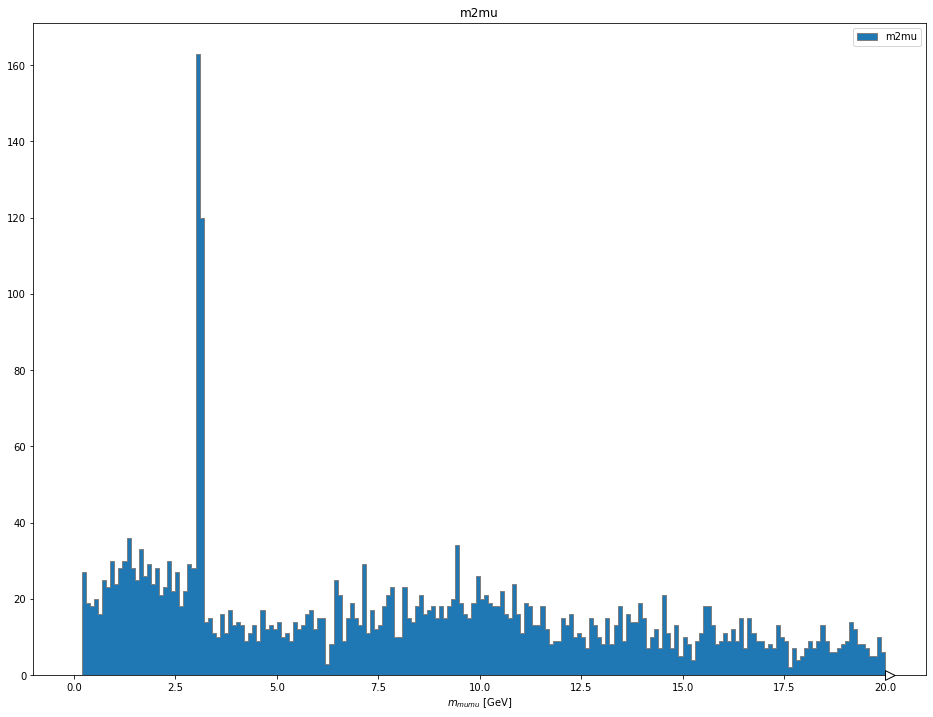

In [26]:
import hist
import matplotlib.pyplot as plt   #TODO move these up
%matplotlib inline
#histogram = hist.Hist.new.Reg(1000, 0, 200,
#                              name="m2mu", label="m2mu [GeV]").Weight()
histogram = hist.Hist.new.Reg(200, 0, 20, name="m2mu", label="m2mu [GeV]").Weight()
histogram.fill(m2mu=allmass_c)
plt.figure(figsize=(16,12))
histogram.plot(histtype="fill", linewidth=1, edgecolor="grey", label='m2mu')
plt.legend()
plt.title("m2mu")
plt.xlabel("$m_{mumu}$ [GeV]");
plt.show()

In [27]:
type(allmass_c)

list

In [28]:
len(allmass_c)

4270